In [1]:
import numpy as np
import os
import cv2 as cv
import scipy.signal as sig
#from scipy.signal import find_peaks_cwt
import git.focus_stack_refinement.support_scripts as supp
import matplotlib.pyplot as plt

In [2]:
def rescale_frame(frame, scale_percentage=100):
    width = int(frame.shape[1] * scale_percentage / 100)
    height = int(frame.shape[0] * scale_percentage / 100)
    dim = (width, height)
    return cv.resize(frame, dim, interpolation=cv.INTER_AREA), width, height

In [3]:
stack_path = 'datasets/for_tests/spinal cord/'

downscale_factor = 50

In [41]:
stack = []
for frame_id in range(0, len(os.listdir(stack_path))):
    stack_frame = cv.imread(stack_path + f'frame{frame_id}.jpg', cv.IMREAD_COLOR)
    stack_frame = cv.cvtColor(stack_frame, cv.COLOR_BGR2GRAY)
    stack_frame, w, h = rescale_frame(stack_frame, downscale_factor)
    stack.append(stack_frame)
res = supp.get_focus_results_from_array(stack, measure='LAPM', to_grayscale=False)

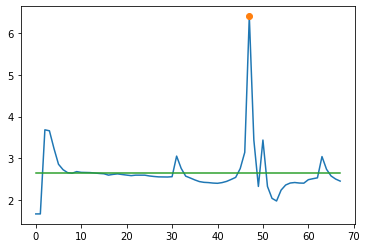

In [75]:
plt.plot(res)

# height, threshold, prominence - по высоте насколько выделяется
# distance - min расстояние между соседними пиками
# width - ширина пика
# всё это может сильно разниться от датасета к датасету
found_peaks_x = sig.find_peaks(res, prominence=2)[0]
found_peaks_y = np.take(res, found_peaks_x)
plt.plot(found_peaks_x, found_peaks_y, 'o')
plt.plot(range(0, len(res)), np.full(len(res), np.mean(res)))


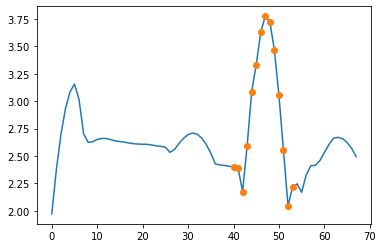

In [108]:
res_smooth = sig.savgol_filter(res, 11, 2)
plt.plot(res_smooth)
avg_res = np.mean(res_smooth)
plt.plot(range(0, len(res)), np.full(len(res), avg_res))
found_peaks_x, peak_props = sig.find_peaks(res_smooth, distance=len(res), width=(1,None))
peak_lower_x = int(found_peaks_x - peak_props['widths'])
peak_lower_y = int(found_peaks_x + peak_props['widths']) + 1
peak_range = range(peak_lower_x, peak_lower_y)

found_peaks_y = res_smooth[found_peaks_x]
plt.plot(peak_range, res_smooth[peak_range], 'o')

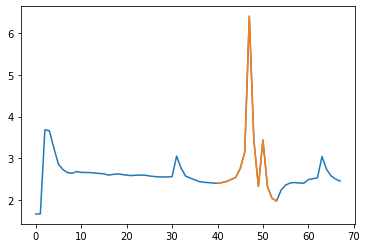

In [107]:
plt.plot(res)
plt.plot(peak_range, np.array(res)[peak_range])

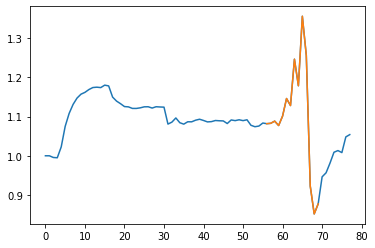

In [6]:
video_path = 'datasets/VIDEOS-CARFULLY-EXTRACT/old_videos/bee_wing_fast.mp4'
supp.find_peak('bee_wing_fast', path_to_video=video_path, focus_measure='LAPM', filter_window=11)

In [4]:
path_to_zip_files = 'datasets/VIDEOS-CARFULLY-EXTRACT/zip-files/'
for dirpath, dirnames, filenames in os.walk(path_to_zip_files):
    if len(filenames) != 0:
        videos = list(filter(lambda x: x[-3:] == 'mp4', filenames))[0:2]
        for video in videos:
            video_dir = dirpath + '/'
            graph_name = dirpath.split('\\')[-1] + '_' + video[0:-4]

            # graph_name = 'pro_' + dirpath.split('\\')[-1] + '_' + video[0:-4]
            # graph_name = 'hd_' + video[0:-4]
            if (graph_name + '.png') not in os.listdir('results/peak_search/'):
                try:
                    supp.find_peak(graph_name, path_to_video=(video_dir + video), focus_measure='LAPM', filter_window=11)
                except RuntimeError:
                    print('Peak not found: ' + graph_name)